<a href="https://colab.research.google.com/github/jafetimbre/ms-school-stuff/blob/master/image-processing/sudoku_rec/sudoku.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solving sudoku using opencv-python, CNN-OCR and an Elitist Evolutionary algorithm (DEAP)

In [1]:
!pip install deap -q

In [2]:
import cv2
import numpy as np
from urllib.request import urlopen, urlretrieve
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from matplotlib import cm    
import random
from deap import creator, base, tools, algorithms
from tensorflow.keras.models import load_model

As a starting point, we have a photo of a sudoku game from a book. That's the base image used to identify and later solve the puzzle.



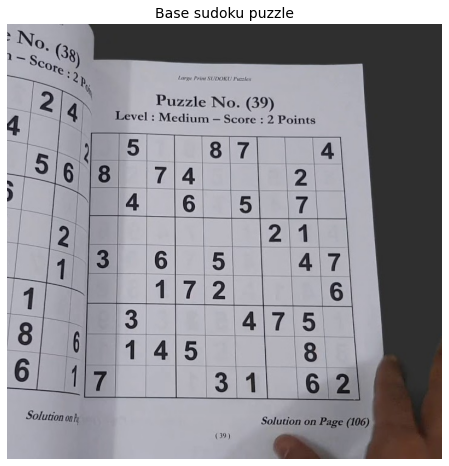

In [3]:
req = urlopen("https://raw.githubusercontent.com/jafetimbre/ms-school-stuff/master/image-processing/sudoku_rec/res/target.jpg")
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)

base_img = cv2.imdecode(arr, -1)
base_h, base_w, _ = base_img.shape

plt.figure(figsize = (16, 8))
plt.axis("off")
plt.title("Base sudoku puzzle", fontsize=14)
plt.imshow(cv2.cvtColor(base_img, cv2.COLOR_BGR2RGB))

We will use a method called contours finding, but in order to achieve the desired result, we need to apply some preprocessing first. In general we used three methods:

1.  Transforming the base image to grayscale
2.  Blurring the image
3.  Applying an adaptive threshold 


This is what the result looks like:


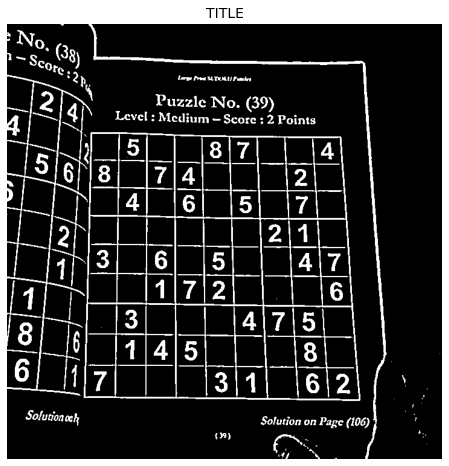

In [4]:
base_gray = cv2.cvtColor(base_img, cv2.COLOR_BGR2GRAY)
base_blur = cv2.GaussianBlur(base_gray, (5, 5), 1)
base_th = cv2.adaptiveThreshold(base_blur, 255, 1, 1, 11, 3)

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("TITLE", fontsize=14)
plt.imshow(cv2.cvtColor(base_th, cv2.COLOR_BGR2RGB))

As a second step, we applied the contour finder. As a result we got this image:


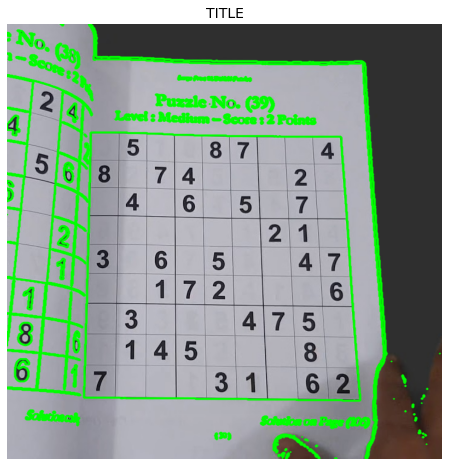

In [5]:
cnts, hr = cv2.findContours(base_th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

cnt_img = base_img.copy()
cv2.drawContours(image=cnt_img, contours=cnts, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("TITLE", fontsize=14)
plt.imshow(cv2.cvtColor(cnt_img, cv2.COLOR_BGR2RGB))

In order to isolate the sudoku from the rest of the image, the biggest area is computed from all possible areas described by the contours.


In [6]:
biggest_contour = None
biggest_contour_area = 0
corners = []

for c in cnts:
    area = cv2.contourArea(c)
    if area > 100:
        p = cv2.arcLength(c, True)
        apx = cv2.approxPolyDP(c, 0.02 * p, True)
        if area > biggest_contour_area and len(apx) == 4:
            corners = apx
            biggest_contour_area = area
            biggest_contour = c

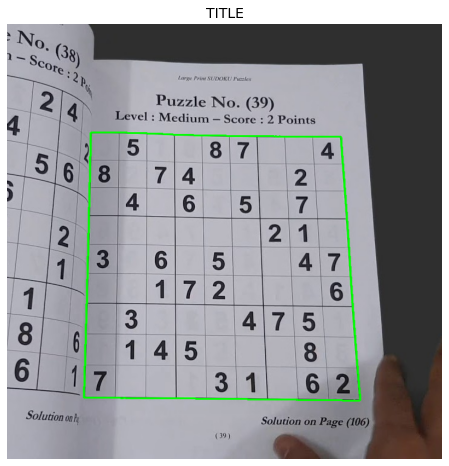

In [7]:
base_big_cnt = base_img.copy()
cv2.drawContours(image=base_big_cnt, contours=biggest_contour, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("TITLE", fontsize=14)
plt.imshow(cv2.cvtColor(base_big_cnt, cv2.COLOR_BGR2RGB))

As you can tell, we successfully found the biggest area and the sudoku location at the same time. Now we can compute the four corner points of the image.



In [8]:
corners_tmp = corners.copy()
corners_tmp = corners_tmp.reshape((4, 2))
corners = np.zeros((4, 1, 2), dtype=np.int32)
s = corners_tmp.sum(1)
corners[0] = corners_tmp[np.argmin(s)]
corners[3] = corners_tmp[np.argmax(s)]
d = np.diff(corners_tmp, axis=1)
corners[1] = corners_tmp[np.argmin(d)]
corners[2] = corners_tmp[np.argmax(d)]

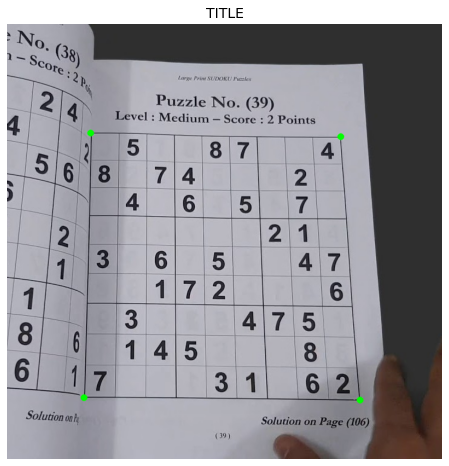

In [9]:
base_corners = base_img.copy()
cv2.drawContours(image=base_corners, contours=corners, contourIdx=-1, color=(0, 255, 0), thickness=10, lineType=cv2.LINE_AA)

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("TITLE", fontsize=14)
plt.imshow(cv2.cvtColor(base_corners, cv2.COLOR_BGR2RGB))

Having those four points, we can transform the perspective of the image to a top-down view, filling the frame in the process.


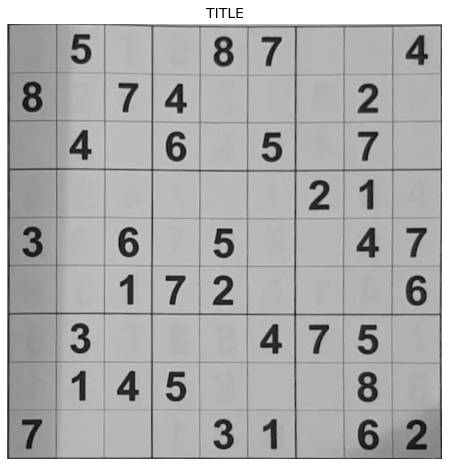

In [10]:
current = np.float32(corners)
wraped = np.float32([[0, 0], [base_w, 0], [0, base_h], [base_w, base_h]])

persp_matrix = cv2.getPerspectiveTransform(current, wraped)

sk_im = cv2.warpPerspective(base_img, persp_matrix, (base_w, base_h))
sk_im = cv2.cvtColor(sk_im, cv2.COLOR_BGR2GRAY)

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("TITLE", fontsize=14)
plt.imshow(cv2.cvtColor(sk_im, cv2.COLOR_BGR2RGB))

Because we want to identify each digit from the puzzle separately, we split the image into cells as follows:


In [11]:
cells = []
rows = np.vsplit(sk_im, 9)
for row in rows:
    cols = np.hsplit(row, 9)
    for cell in cols:
        cells.append(cell)

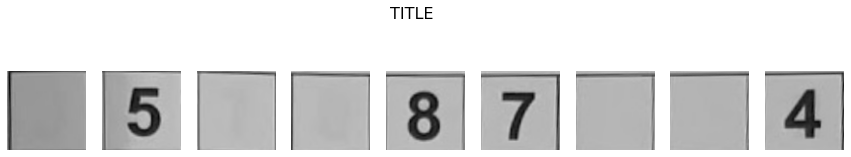

In [12]:
fig, axs = plt.subplots(1, 9, figsize=(15,3))
fig.suptitle("TITLE", fontsize=16)
for i, im in enumerate(cells[:9]):
    axs[i].axis("off")
    axs[i].imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

Now that we have the image prepared for OCR, we can import the pre-trained CNN model.

In [13]:
urlretrieve('https://github.com/jafetimbre/ms-school-stuff/raw/master/image-processing/sudoku_rec/res/model.h5', 'model.h5')
MODEL_PATH = './model.h5'

In [14]:
model = load_model(MODEL_PATH)

We can apply the classification model to each cell respectively.


In [15]:
results = []
cells[5] = cells[11]

for cell in cells:
    cell_im = np.asarray(cell)
    cell_im = cell_im[4:cell_im.shape[0]-4, 4:cell_im.shape[1]-4]
    cell_im = cv2.resize(cell_im, (28, 28))
    cell_im = cell_im / 255
    cell_im = cell_im.reshape(1, 28, 28, 1)

    pred = model.predict(cell_im)
    val_idx = np.argmax(pred, axis=-1)
    probVal = np.amax(pred)

    if probVal > .60:
        results.append(val_idx[0])
    else:
        results.append(0)

As a result we got the a list with the class values that looks like this:


In [16]:
print(results)

[0, 5, 0, 0, 8, 7, 0, 0, 4, 8, 0, 7, 4, 0, 0, 0, 2, 0, 0, 4, 0, 6, 0, 5, 0, 7, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 3, 0, 6, 0, 5, 0, 0, 4, 7, 0, 0, 1, 7, 2, 0, 0, 0, 6, 0, 3, 0, 0, 0, 4, 7, 5, 0, 0, 1, 4, 5, 0, 0, 0, 8, 0, 7, 0, 0, 0, 3, 1, 0, 6, 2]


Now we can display the digitized and the real version side by side.


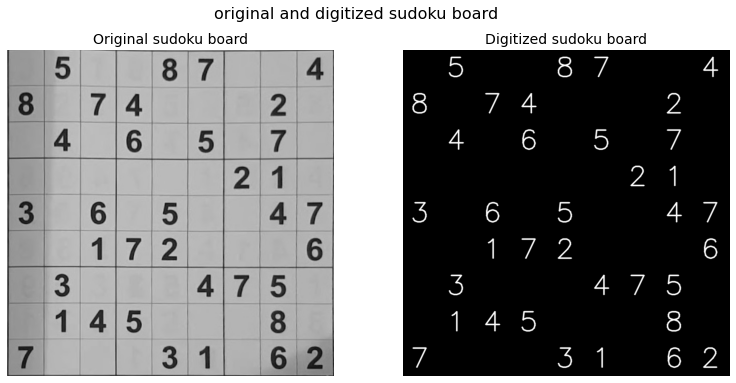

In [17]:
sk_im_w, sk_im_h = sk_im.shape
sk_unsolved = np.zeros((sk_im_h, sk_im_w, 3), np.uint8)
im_s_w = int(sk_unsolved.shape[1]/9)
im_s_h = int(sk_unsolved.shape[0]/9)

for i in range(0, 9):
    for j in range(0, 9):
        val = results[(i*9)+j]
        if val != 0:
            cv2.putText(sk_unsolved, str(val), (int((j+0.2)*im_s_h), i*im_s_w+int(im_s_w/2)+20), cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, 2, (255, 255, 255), 2, cv2.LINE_AA)

fig, axs = plt.subplots(1, 2, figsize=(13, 6))
fig.suptitle("original and digitized sudoku board", fontsize=16)
titles = [ "Original sudoku board", "Digitized sudoku board" ]
for i, im in enumerate([sk_im, sk_unsolved]):
    axs[i].axis("off")
    axs[i].set_title(titles[i], fontsize=14)
    axs[i].imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

For the Elitist Evolutionary Algorithm (EEA), we need to transform the result matrix into a position matrix.

In [18]:
BOARD_CONFIG = []

for idx, val in enumerate(results):
    if (val > 0):
        i = int(idx / 9)
        j = idx % 9
        BOARD_CONFIG.append((val, i, j))

BOARD_CONFIG = np.asarray(BOARD_CONFIG)

We will create a function that will display the board state using an image.


In [19]:
def draw_board(board_state):
    sk_im_w, sk_im_h = sk_im.shape
    im = np.zeros((sk_im_h, sk_im_w, 3), np.uint8)
    im_s_w = int(im.shape[1]/9)
    im_s_h = int(im.shape[0]/9)

    board_conf_cords = list(zip(BOARD_CONFIG.T[1], BOARD_CONFIG.T[2]))

    for i in range(0, 9):
        for j in range(0, 9):
            val = board_state[i][j]
            if (i, j) in board_conf_cords:
                cv2.putText(im, str(val), (int((j+0.2)*im_s_h), i*im_s_w+int(im_s_w/2)+20), cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, 2, (255, 255, 255), 5, cv2.LINE_AA)
            else:
                cv2.putText(im, str(val), (int((j+0.2)*im_s_h), i*im_s_w+int(im_s_w/2)+20), cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, 2, (0, 255, 0), 1, cv2.LINE_AA)

    plt.figure(figsize = (8, 8))
    plt.axis("off")
    plt.title("Board state", fontsize=14)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

The following function is used by the EEA to transform an individual to a board configuration.

In [20]:
def individual_to_board(individual):
    flat_init_state_indx = list(map(lambda t: t[1]*9 + t[2], BOARD_CONFIG))
    values = BOARD_CONFIG.T[0]
    flat_board = []
    init_values_count = 0

    for i in range(81):
        if (i in flat_init_state_indx):
            flat_board.append(values[init_values_count])
            init_values_count += 1
            continue
        flat_board.append(individual[i - init_values_count])
    return np.array(flat_board).reshape(9,9)

In [21]:
def draw_board_from_ind(individual):
    board_from_ind = individual_to_board(individual)
    draw_board(board_from_ind)

For the EEA, we need a fitness function that can tell the difference between bad and good individuals from the population. To quantify this we use the standard rules of sudoku.

In [22]:
def board_fitness(board_state):
    fitness = 0
    nr_rows, nr_cols = board_state.shape

    # row/col verification
    for row in board_state:
        fitness += len(np.unique(row))
    for col in board_state.T:
        fitness += len(np.unique(col))

    # 3x3 cell verification
    for i in range(0, 3):
        for j in range(0, 3):
            board_group = board_state[3*i:3*i+3, 3*j:3*j+3]
            fitness += len(np.unique(board_group))
    
    return fitness

In [23]:
def individual_fitness(individual):
    board_from_ind = individual_to_board(individual)
    return board_fitness(board_from_ind),

The EEA needs some starting individuals to work with, so we created an individual generator that gives random board configurations filling the empty cells with random numbers.


In [24]:
def generate_random_individual():
    board = (np.indices((9,9)) + 1)[1]

    for i in range(len(board)):
        board[i] = np.random.permutation(board[i])
    
    for (val, row, col) in BOARD_CONFIG:
        value_index = np.where(board[row]==val)[0][0]
        board[row][value_index], board[row][col] = board[row][col], board[row][value_index]

    fixed_values_mask = np.ones((9,9), dtype=bool)
    for (val, row, col) in BOARD_CONFIG:
        fixed_values_mask[row][col] = False

    return board[fixed_values_mask].tolist()

To test that, we created this individual. As you can see, it violates the rules of sudoku and it doesn’t have a good fitness score.


The fitness of the test individual is: 202/243


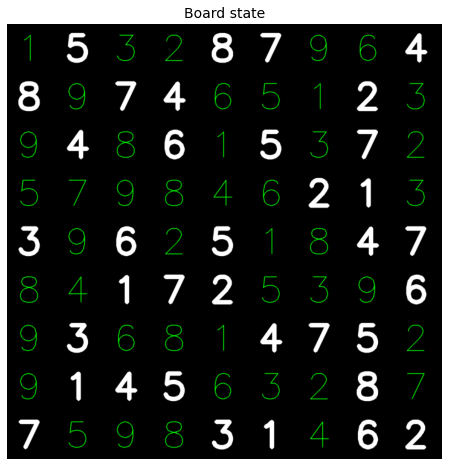

In [25]:
test_individual = generate_random_individual()
fintess_test_ind = individual_fitness(test_individual)

draw_board_from_ind(test_individual)
print(f'\nThe fitness of the test individual is: {fintess_test_ind[0]}/243')

Now we can create the actual EEA method that is responsible for the evolutiv process.

In [26]:
def ea_simple_elitist(population, toolbox, cxpb, mutpb, ngen, callback=None, stats=None, halloffame=None, verbose=__debug__):
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is None:
        # elitist version
        raise ValueError("halloffame parameter must not be empty!")
    
    halloffame.update(population)
    hof_size = len(halloffame.items) if halloffame.items else 0

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    for gen in range(1, ngen + 1):
        # Selecting the individuals for the next generation
        # (except the elit individuals witch are copied: -hof_size)
        offspring = toolbox.select(population, len(population) - hof_size)
    
        # applying some variation opeators
        offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)

        # computing the fitness 
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        
        # elitist mechanism, the best individuals advance to the hall of fame
        offspring.extend(halloffame.items)
        halloffame.update(offspring)

        # Swaping the population with the offspring
        population[:] = offspring

        # Getting the statistic logs
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

        if callback:
            callback(gen, halloffame.items[0])

    return population, logbook

We define some hyperparameters for the method.

In [27]:
NR_POPULATION = 5000
NR_GENERATIONS = 50

MUTATION_PROB = 0.3
CROSSOVER_PROB = 0.8

HOF_SIZE = 10
TOURNAMENT_SIZE = 3

Using the DEAP framework, we ansamble all the parts described earlier.

In [28]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create('Individual', list, fitness=creator.FitnessMax)

In [29]:
toolbox = base.Toolbox()

toolbox.register('gen_rand_ind', generate_random_individual)
toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.gen_rand_ind)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)

In [30]:
toolbox.register("evaluate", individual_fitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=1, up=9, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=TOURNAMENT_SIZE)

population = toolbox.population(n=NR_POPULATION)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("max", np.max)
stats.register("avg", np.mean)
stats.register("std", np.std)

hof = tools.HallOfFame(HOF_SIZE)

All the components are ready, we can start the sudoku solving process by starting the EEA.

In [31]:
%%time
population, logbook = ea_simple_elitist(population,
                                        toolbox,
                                        cxpb=CROSSOVER_PROB,
                                        mutpb=MUTATION_PROB,
                                        ngen=NR_GENERATIONS,
                                        stats=stats,
                                        halloffame=hof,
                                        verbose=True)

gen	nevals	min	max	avg   	std    
0  	5000  	186	220	201.17	4.32748
1  	4263  	187	220	202.403	4.22509
2  	4330  	187	220	203.395	4.23752
3  	4335  	186	222	204.454	4.31327
4  	4259  	187	222	205.435	4.3855 
5  	4267  	190	225	206.535	4.38173
6  	4281  	189	225	207.613	4.39527
7  	4312  	192	225	208.777	4.40319
8  	4320  	192	226	209.863	4.4654 
9  	4309  	195	226	211.275	4.37963
10 	4348  	194	229	212.448	4.34079
11 	4353  	195	229	213.556	4.37013
12 	4237  	196	229	214.898	4.34594
13 	4289  	198	230	216.109	4.37549
14 	4272  	202	230	217.344	4.32652
15 	4328  	200	231	218.539	4.19748
16 	4317  	202	231	219.586	4.16949
17 	4316  	201	234	220.682	4.18579
18 	4271  	203	236	221.911	4.21096
19 	4287  	206	236	223.111	4.09142
20 	4292  	203	238	224.162	4.25242
21 	4285  	206	238	225.404	4.10998
22 	4276  	210	238	226.498	4.11675
23 	4270  	209	239	227.669	4.14104
24 	4275  	210	241	229.023	4.02717
25 	4301  	208	241	230.255	4.08308
26 	4325  	211	241	231.453	4.08795
27 	4293  	210	243	232

As a result we got one of the best solutions to the puzzle, with the maximum fitness score.


In [32]:
best = hof.items[0]
best_solution = best.copy()
print(f"Best Solution: {best_solution}")
print(f"Best Score: {best.fitness.values[0]} / 243\n")

Best Solution: [1, 3, 2, 6, 9, 6, 9, 3, 1, 5, 2, 9, 1, 3, 8, 5, 7, 8, 3, 4, 6, 9, 2, 1, 9, 8, 4, 9, 8, 5, 3, 9, 2, 8, 6, 1, 6, 7, 2, 9, 3, 8, 5, 9, 4]
Best Score: 243.0 / 243



If we display this solution, we will get this image:

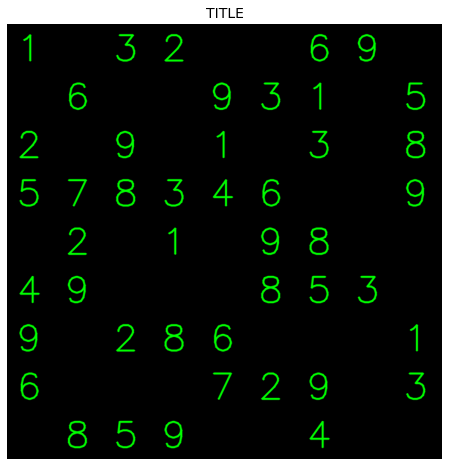

In [33]:
sk_im_w, sk_im_h = sk_im.shape
sk_solved = np.zeros((sk_im_h, sk_im_w, 3), np.uint8)
im_s_w = int(sk_solved.shape[1]/9)
im_s_h = int(sk_solved.shape[0]/9)

board_conf_cords = list(zip(BOARD_CONFIG.T[1], BOARD_CONFIG.T[2]))
loc_best = best.copy()

for i in range(0, 9):
    for j in range(0, 9):
        if (i, j) not in board_conf_cords:
            val = loc_best.pop(0)
            cv2.putText(sk_solved, str(val), (int((j+0.2)*im_s_h), i*im_s_w+int(im_s_w/2)+20), cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, 2, (0, 255, 0), 2, cv2.LINE_AA)

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("TITLE", fontsize=14)
plt.imshow(cv2.cvtColor(sk_solved, cv2.COLOR_BGR2RGB))

Now we can overlay the solution image on the original puzzle and we are done. We solved this puzzle.


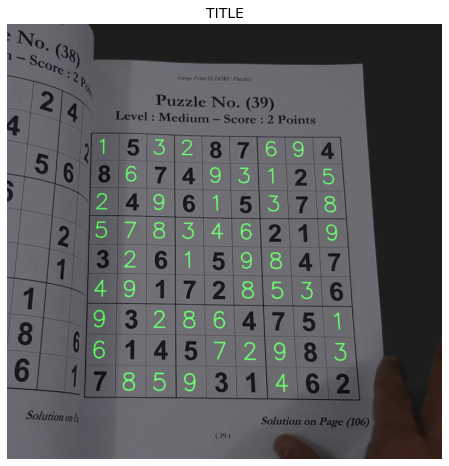

In [34]:
current = np.float32(corners)
wraped = np.float32([[0, 0], [base_w, 0], [0, base_h], [base_w, base_h]])

persp_matrix = cv2.getPerspectiveTransform(wraped, current)

base_solved = cv2.warpPerspective(sk_solved, persp_matrix, (base_w, base_h))
base_solved = cv2.addWeighted(base_solved, 1, base_img, 0.6, 1)

plt.figure(figsize = (8, 8))
plt.axis("off")
plt.title("TITLE", fontsize=14)
plt.imshow(cv2.cvtColor(base_solved, cv2.COLOR_BGR2RGB))